In [2]:
# === 1) БАЗОВІ ПАКЕТИ ТА PYTORCH (CUDA 12.1) ===
%pip install --upgrade pip wheel setuptools

# PyTorch з підтримкою CUDA (під твій драйвер CUDA 12.9 сумісно з cu129)
%pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

# Корисні бібліотеки для ноутбука і нашого пайплайна
%pip install numpy pillow matplotlib opencv-python "albumentations>=2.0.0,<3.0" tqdm ipywidgets kaggle

# Спроба поставити готове колесо pycocotools
%pip install pycocotools

# === 2) FALLBACK: якщо pycocotools не імпортується, збираємо з джерел ===
import importlib, sys, subprocess
try:
    importlib.import_module("pycocotools")
except Exception as e:
    print("pycocotools wheel недоступний для цієї версії Python. Ставимо з джерел…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cython"])
    subprocess.check_call([
        sys.executable, "-m", "pip", "install",
        "git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI"
    ])
try:
    import sys, subprocess
    subprocess.run(
        [sys.executable, "-m", "jupyter", "nbextension", "enable", "--py", "widgetsnbextension", "--sys-prefix"],
        check=False
    )
except Exception:
    pass





  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 70.2.0
    Uninstalling setuptools-70.2.0:
      Successfully uninstalled setuptools-70.2.0
Note: you may need to restart the kernel to use updated packages.Looking in indexes: https://download.pytorch.org/whl/cu129
  Using cached https://download.pytorch.org/whl/cu129/torch-2.8.0%2Bcu129-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/cu129/torchvision-0.23.0%2Bcu129-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu129/torchaudio-2.8.0%2Bcu129-cp312-cp312-win_amd64.whl.metadata (7.4 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\dazap\\appdata\\local\\programs\\python\\python312\\lib\\site-packages\\torch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [3]:
# === 3) ШВИДКА ПЕРЕВІРКА СЕРЕДОВИЩА ===
import torch, albumentations as A, numpy as np, cv2, PIL, matplotlib
print("torch:", torch.__version__, "| CUDA available?:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("torchvision:", __import__("torchvision").__version__)
print("albumentations:", A.__version__)
print("numpy:", np.__version__)
print("opencv:", cv2.__version__)
print("Pillow:", PIL.__version__)
print("matplotlib:", matplotlib.__version__)

torch: 2.8.0+cu129 | CUDA available?: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
torchvision: 0.23.0+cu129
albumentations: 2.0.8
numpy: 2.1.2
opencv: 4.12.0
Pillow: 11.0.0
matplotlib: 3.10.3


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # швидші kernels для стабільного розміру
print("Train on:", device)

Train on: cuda


In [5]:
import json
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from collections import Counter, defaultdict
import cv2
from tqdm.auto import tqdm
import pandas as pd

# Налаштування відображення
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [6]:
class COCODataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
            annotation_file (string): Path to the COCO annotation file
            transform (callable, optional): Optional transform to be applied on images
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create dictionaries for quick lookup
        self.images = {img['id']: img for img in self.coco_data['images']}
        self.categories = {cat['id']: cat for cat in self.coco_data['categories']}
        
        # Group annotations by image_id for faster access
        self.image_annotations = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.image_annotations[ann['image_id']].append(ann)
        
        # List of all image ids to use for indexing
        self.image_ids = list(self.images.keys())
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """Return image and its annotations"""
        image_id = self.image_ids[idx]
        img_info = self.images[image_id]
        file_name = img_info['file_name']
        
        # Load image
        img_path = os.path.join(self.root_dir, file_name)
        image = Image.open(img_path).convert('RGB')
        
        # Get annotations for this image
        annotations = self.image_annotations[image_id]
        
        # Extract bounding boxes, class labels, and segmentation masks
        boxes = []
        labels = []
        areas = []
        segmentations = []
        iscrowd = []
        
        for ann in annotations:
            boxes.append(ann['bbox'])  # [x, y, width, height]
            labels.append(ann['category_id'])
            areas.append(ann['area'])
            segmentations.append(ann['segmentation'])
            iscrowd.append(ann['iscrowd'])
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        
        # Prepare target dict
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': areas,
            'iscrowd': iscrowd,
            'segmentations': segmentations
        }
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, target
    
    def get_img_info(self, idx):
        """Get image info by index"""
        image_id = self.image_ids[idx]
        return self.images[image_id]
    
    def get_category_name(self, category_id):
        """Get category name from id"""
        return self.categories[category_id]['name']
    
    def get_category_info(self):
        """Get all category information"""
        return self.categories

In [7]:
# Define dataset paths - adjust these to your file locations
COCO_ROOT = '../coco2017'
TRAIN_ROOT = os.path.join(COCO_ROOT, 'train2017')
VAL_ROOT = os.path.join(COCO_ROOT, 'val2017')
TRAIN_ANNOTATION = os.path.join(COCO_ROOT, 'annotations', 'instances_train2017.json')
VAL_ANNOTATION = os.path.join(COCO_ROOT, 'annotations', 'instances_val2017.json')

# Check if the files exist
if not os.path.exists(TRAIN_ROOT):
    print(f"Warning: {TRAIN_ROOT} directory not found!")
if not os.path.exists(VAL_ROOT):
    print(f"Warning: {VAL_ROOT} directory not found!")
if not os.path.exists(TRAIN_ANNOTATION):
    print(f"Warning: {TRAIN_ANNOTATION} file not found!")
if not os.path.exists(VAL_ANNOTATION):
    print(f"Warning: {VAL_ANNOTATION} file not found!")

# Initialize datasets
try:
    train_dataset = COCODataset(TRAIN_ROOT, TRAIN_ANNOTATION)
    val_dataset = COCODataset(VAL_ROOT, VAL_ANNOTATION)
    print(f"Training dataset size: {len(train_dataset)} images")
    print(f"Validation dataset size: {len(val_dataset)} images")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Attempting to load just annotation files for analysis...")
    with open(TRAIN_ANNOTATION, 'r') as f:
        train_data = json.load(f)
    with open(VAL_ANNOTATION, 'r') as f:
        val_data = json.load(f)
        
        
def segmentation_format_stats(data):
    """
    Повертає статистику по полям 'segmentation':
    - total_annotations: загальна к-сть анотацій
    - with_seg: к-сть анотацій з масками
    - poly / rle: к-сть полігональних / RLE масок
    - відсоткові частки
    """
    anns = data['annotations']
    n = len(anns)
    has_seg = 0
    poly = 0
    rle = 0
    for a in anns:
        seg = a.get('segmentation', None)
        if not seg:
            continue
        has_seg += 1
        # RLE — це dict з ключем 'counts'; полігони — список координат
        if isinstance(seg, dict) and 'counts' in seg:
            rle += 1
        else:
            poly += 1

    return {
        'total_annotations': n,
        'with_seg': has_seg,
        'poly': poly,
        'rle': rle,
        'with_seg_pct': round(100.0 * has_seg / n, 2) if n else 0.0,
        'poly_pct_of_seg': round(100.0 * poly / has_seg, 2) if has_seg else 0.0,
        'rle_pct_of_seg': round(100.0 * rle / has_seg, 2) if has_seg else 0.0
    }

# Виклик для train/val:
try:
    seg_train = segmentation_format_stats(train_data)
except NameError:
    seg_train = segmentation_format_stats(train_dataset.coco_data)

try:
    seg_val = segmentation_format_stats(val_data)
except NameError:
    seg_val = segmentation_format_stats(val_dataset.coco_data)

print("Train segmentation stats:", seg_train)
print("Val segmentation stats:  ", seg_val)
        

Training dataset size: 118287 images
Validation dataset size: 5000 images
Train segmentation stats: {'total_annotations': 860001, 'with_seg': 860001, 'poly': 849949, 'rle': 10052, 'with_seg_pct': 100.0, 'poly_pct_of_seg': 98.83, 'rle_pct_of_seg': 1.17}
Val segmentation stats:   {'total_annotations': 36781, 'with_seg': 36781, 'poly': 36335, 'rle': 446, 'with_seg_pct': 100.0, 'poly_pct_of_seg': 98.79, 'rle_pct_of_seg': 1.21}


In [8]:
# Function to analyze a COCO dataset from annotations
def analyze_coco_dataset(data, name="Dataset"):
    print(f"=== {name} Analysis ===")
    
    # Basic counts
    n_images = len(data['images'])
    n_annotations = len(data['annotations'])
    n_categories = len(data['categories'])
    
    print(f"Number of images: {n_images}")
    print(f"Number of annotations: {n_annotations}")
    print(f"Number of categories: {n_categories}")
    print(f"Average annotations per image: {n_annotations / n_images:.2f}")
    
    # Get all category names
    categories = {cat['id']: cat['name'] for cat in data['categories']}
    supercategories = {cat['id']: cat['supercategory'] for cat in data['categories']}
    
    # Count annotations per category
    category_counts = Counter([ann['category_id'] for ann in data['annotations']])
    
    # Create a DataFrame for better visualization
    categories_df = pd.DataFrame({
        'category_id': list(categories.keys()),
        'name': list(categories.values()),
        'supercategory': [supercategories[cat_id] for cat_id in categories.keys()],
        'count': [category_counts.get(cat_id, 0) for cat_id in categories.keys()]
    })
    
    categories_df = categories_df.sort_values('count', ascending=False)
    
    # Display top 10 categories
    print("\nTop 10 most common categories:")
    print(categories_df.head(10)[['name', 'supercategory', 'count']])
    
    # Group by supercategory
    supercategory_counts = categories_df.groupby('supercategory').agg({'count': 'sum'})
    supercategory_counts = supercategory_counts.sort_values('count', ascending=False)
    
    print("\nAnnotations per supercategory:")
    print(supercategory_counts.head(10))
    
    return categories_df, supercategory_counts

# Analyze datasets
train_categories_df, train_supercategories = analyze_coco_dataset(train_dataset.coco_data, "Training Dataset")
val_categories_df, val_supercategories = analyze_coco_dataset(val_dataset.coco_data, "Validation Dataset")
    
    
    

=== Training Dataset Analysis ===
Number of images: 118287
Number of annotations: 860001
Number of categories: 80
Average annotations per image: 7.27

Top 10 most common categories:
             name supercategory   count
0          person        person  262465
2             car       vehicle   43867
56          chair     furniture   38491
73           book        indoor   24715
39         bottle       kitchen   24342
41            cup       kitchen   20650
60   dining table     furniture   15714
45           bowl       kitchen   14358
9   traffic light       outdoor   12884
26        handbag     accessory   12354

Annotations per supercategory:
                count
supercategory        
person         262465
vehicle         96212
kitchen         86677
furniture       76985
food            63512
animal          62566
sports          50940
indoor          46088
accessory       45193
electronic      28029
=== Validation Dataset Analysis ===
Number of images: 5000
Number of annotations: 

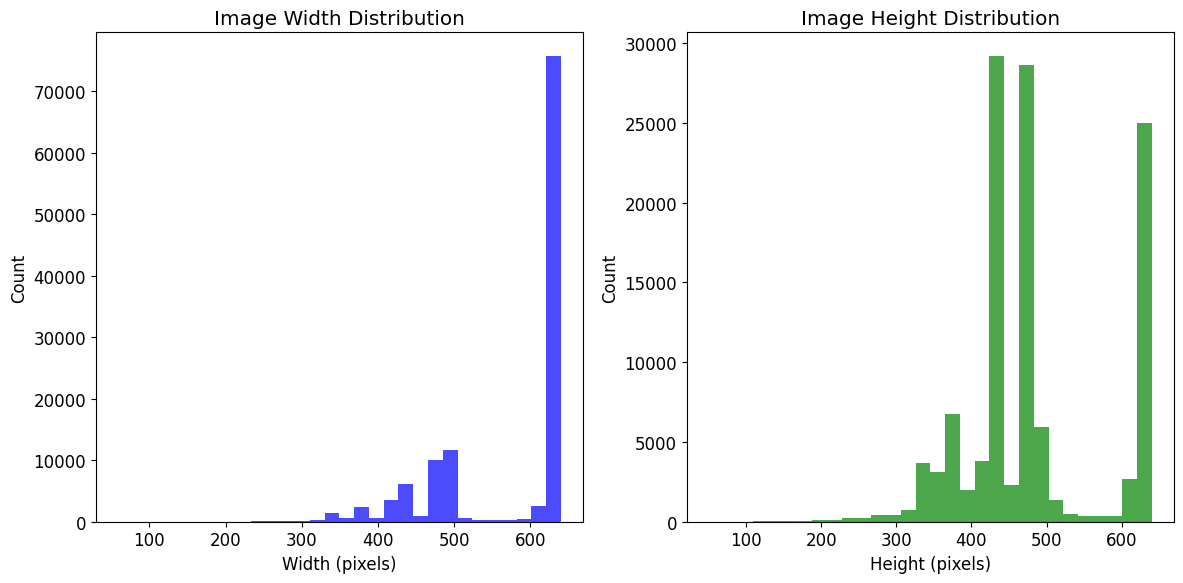

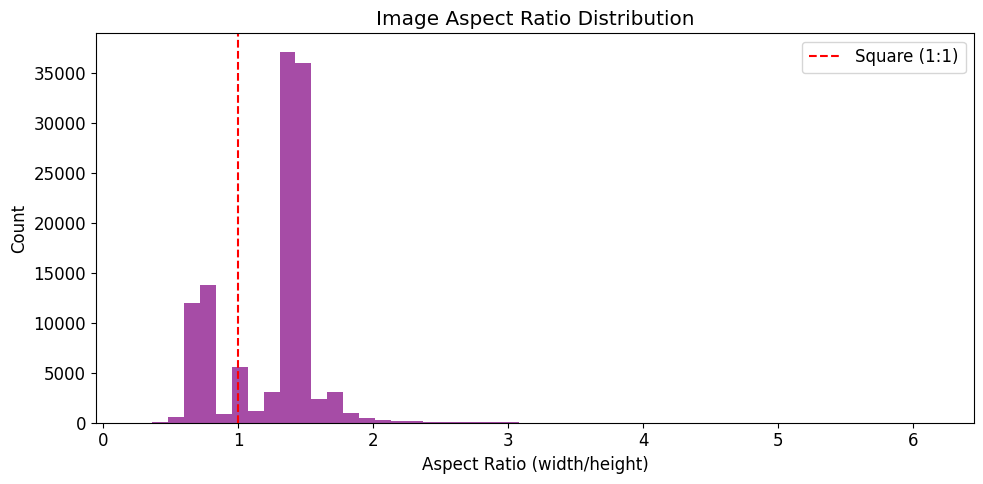

Mean image dimensions: 577.7 x 484.1 pixels
Median image dimensions: 640.0 x 480.0 pixels
Min image dimensions: 59 x 51 pixels
Max image dimensions: 640 x 640 pixels


In [9]:
# Analyze image dimensions
def analyze_image_dimensions(data):
    widths = [img['width'] for img in data['images']]
    heights = [img['height'] for img in data['images']]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, alpha=0.7, color='blue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, alpha=0.7, color='green')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate aspect ratios
    aspect_ratios = [w/h for w, h in zip(widths, heights)]
    
    plt.figure(figsize=(10, 5))
    plt.hist(aspect_ratios, bins=50, alpha=0.7, color='purple')
    plt.title('Image Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (width/height)')
    plt.ylabel('Count')
    plt.axvline(x=1.0, color='red', linestyle='--', label='Square (1:1)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Mean image dimensions: {np.mean(widths):.1f} x {np.mean(heights):.1f} pixels")
    print(f"Median image dimensions: {np.median(widths):.1f} x {np.median(heights):.1f} pixels")
    print(f"Min image dimensions: {np.min(widths)} x {np.min(heights)} pixels")
    print(f"Max image dimensions: {np.max(widths)} x {np.max(heights)} pixels")

try:
    analyze_image_dimensions(train_data)
except:
    analyze_image_dimensions(train_dataset.coco_data)

C:\Users\dazap\AppData\Local\Temp\ipykernel_13920\3656641363.py:49: RuntimeWarning: divide by zero encountered in divide
  aspect_ratios = widths / heights


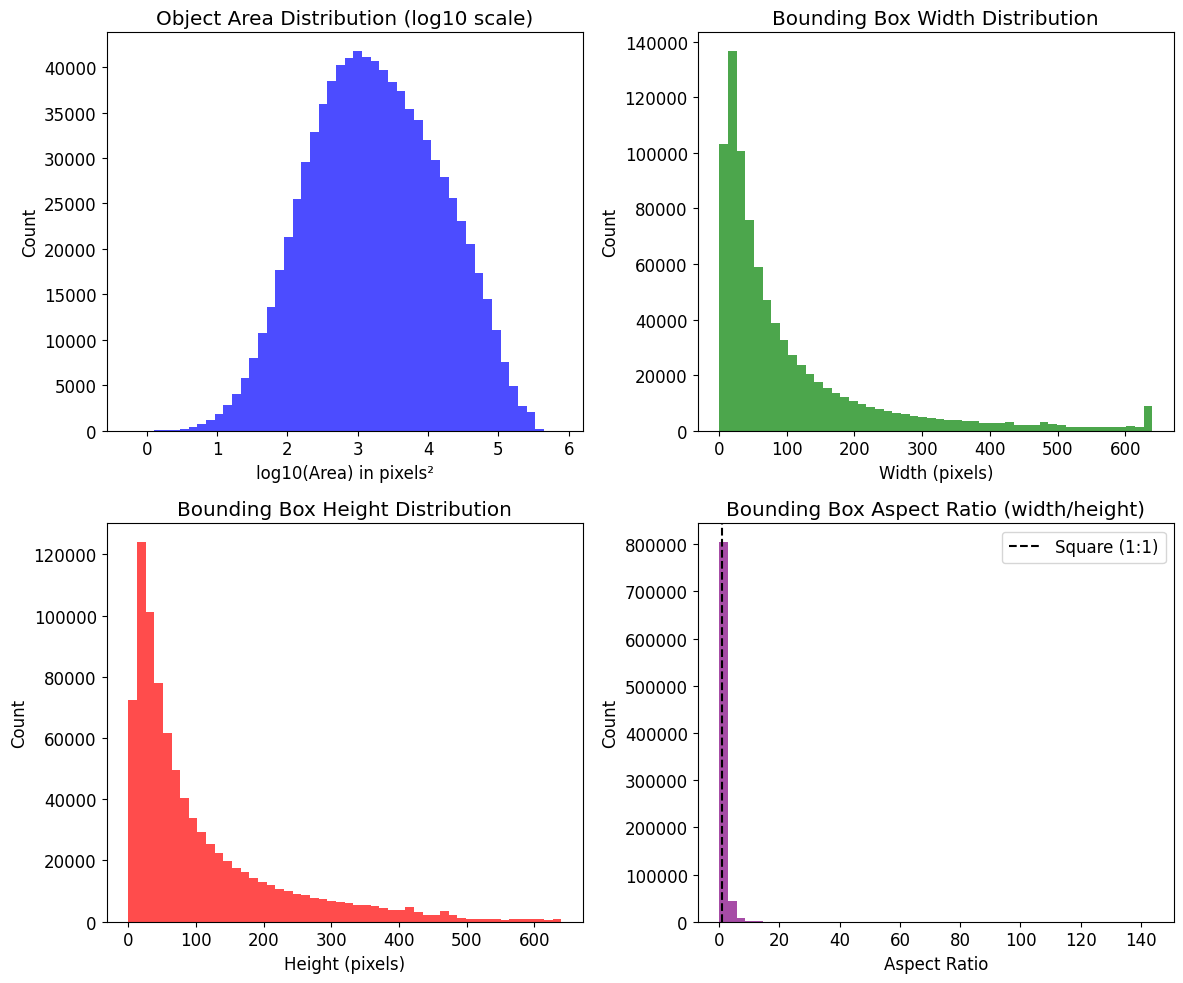

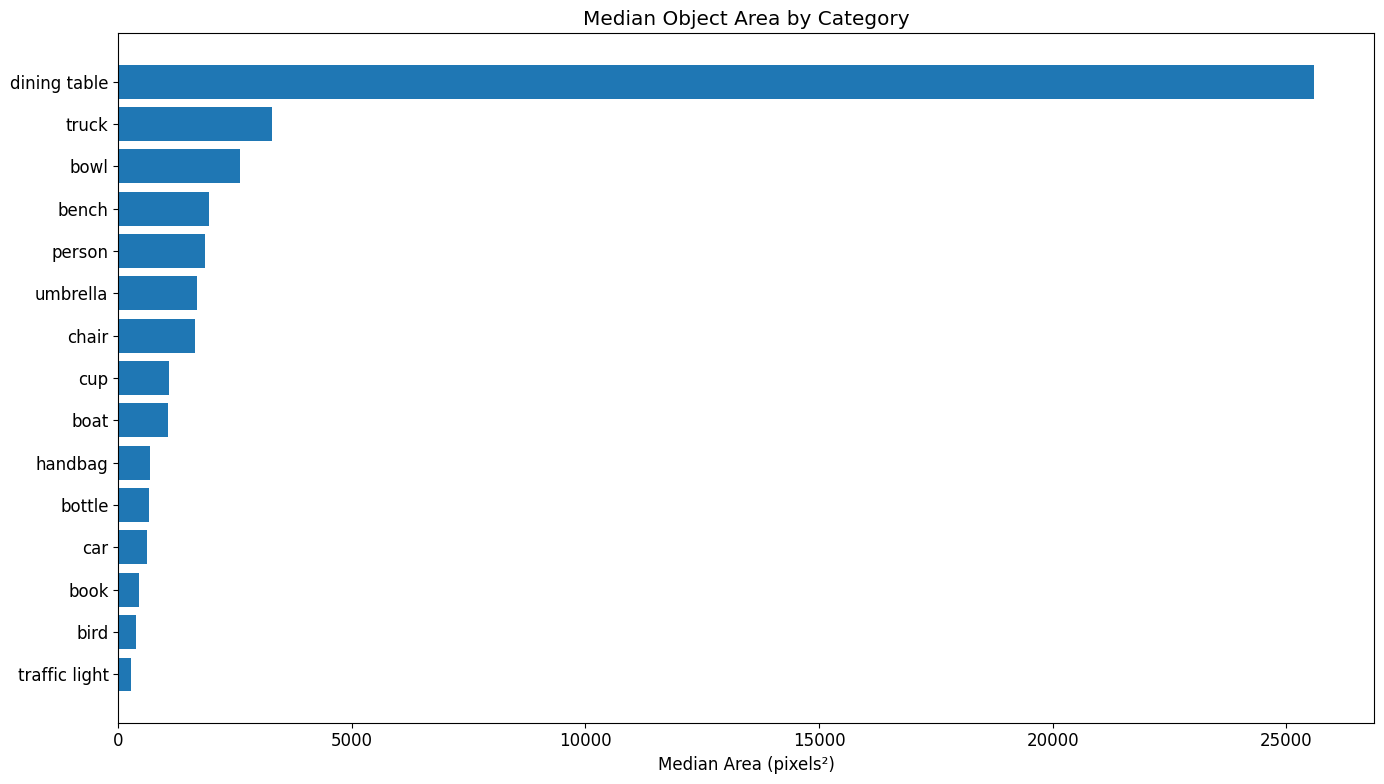

Mean bounding box dimensions: 103.9 x 107.4 pixels
Median bounding box dimensions: 54.1 x 62.3 pixels
Mean object area: 12025.9 pixels²
Median object area: 1697.1 pixels²


In [10]:
# Analyze bounding boxes
def analyze_bounding_boxes(data, categories):
    # Extract bbox information
    bboxes = []
    areas = []
    category_ids = []
    
    for ann in data['annotations']:
        if 'bbox' in ann:
            bboxes.append(ann['bbox'])  # [x, y, width, height]
            areas.append(ann['area'])
            category_ids.append(ann['category_id'])
    
    bboxes = np.array(bboxes)
    areas = np.array(areas)
    
    # Filter out zero or negative areas for log calculation
    valid_areas = areas[areas > 0]
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    if len(valid_areas) > 0:
        plt.hist(np.log10(valid_areas), bins=50, alpha=0.7, color='blue')
        plt.title('Object Area Distribution (log10 scale)')
        plt.xlabel('log10(Area) in pixels²')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No valid areas to display', 
                horizontalalignment='center', verticalalignment='center')
    
    # Box dimensions
    widths = bboxes[:, 2]
    heights = bboxes[:, 3]
    
    plt.subplot(2, 2, 2)
    plt.hist(widths, bins=50, alpha=0.7, color='green')
    plt.title('Bounding Box Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 3)
    plt.hist(heights, bins=50, alpha=0.7, color='red')
    plt.title('Bounding Box Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 4)
    aspect_ratios = widths / heights
    # Filter out infinite or NaN values
    valid_ratios = aspect_ratios[np.isfinite(aspect_ratios)]
    plt.hist(valid_ratios, bins=50, alpha=0.7, color='purple')
    plt.title('Bounding Box Aspect Ratio (width/height)')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Count')
    plt.axvline(x=1.0, color='black', linestyle='--', label='Square (1:1)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
    # Area by category
    plt.figure(figsize=(14, 8))
    category_names = []
    median_areas = []
    
    # Get top 15 categories by count
    top_categories = Counter(category_ids).most_common(15)
    for cat_id, count in top_categories:
        cat_areas = [area for area, cid in zip(areas, category_ids) if cid == cat_id]
        if cat_areas:
            category_names.append(categories[cat_id])
            median_areas.append(np.median(cat_areas))
    
    # Sort by median area
    sorted_indices = np.argsort(median_areas)
    sorted_names = [category_names[i] for i in sorted_indices]
    sorted_areas = [median_areas[i] for i in sorted_indices]
    
    plt.barh(sorted_names, sorted_areas)
    plt.title('Median Object Area by Category')
    plt.xlabel('Median Area (pixels²)')
    plt.tight_layout()
    plt.show()
    
    print(f"Mean bounding box dimensions: {np.mean(widths):.1f} x {np.mean(heights):.1f} pixels")
    print(f"Median bounding box dimensions: {np.median(widths):.1f} x {np.median(heights):.1f} pixels")
    print(f"Mean object area: {np.mean(areas):.1f} pixels²")
    print(f"Median object area: {np.median(areas):.1f} pixels²")

try:
    categories_dict = {cat['id']: cat['name'] for cat in train_data['categories']}
    analyze_bounding_boxes(train_data, categories_dict)
except:
    categories_dict = {cat_id: info['name'] for cat_id, info in train_dataset.categories.items()}
    analyze_bounding_boxes(train_dataset.coco_data, categories_dict)

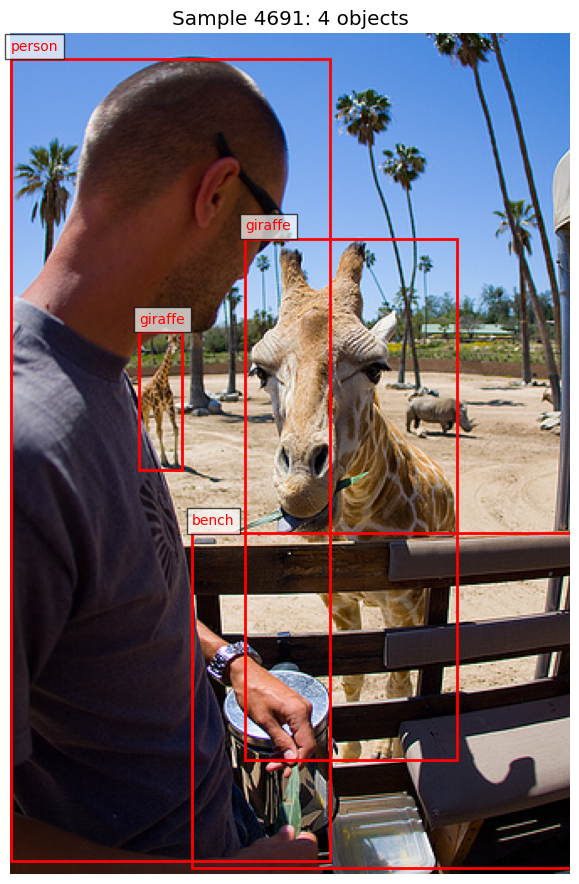

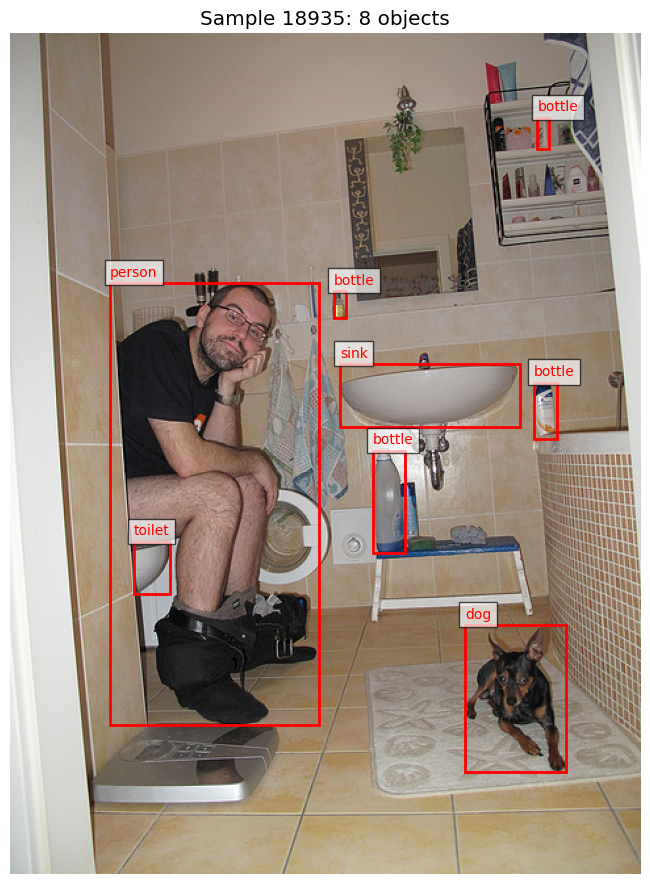

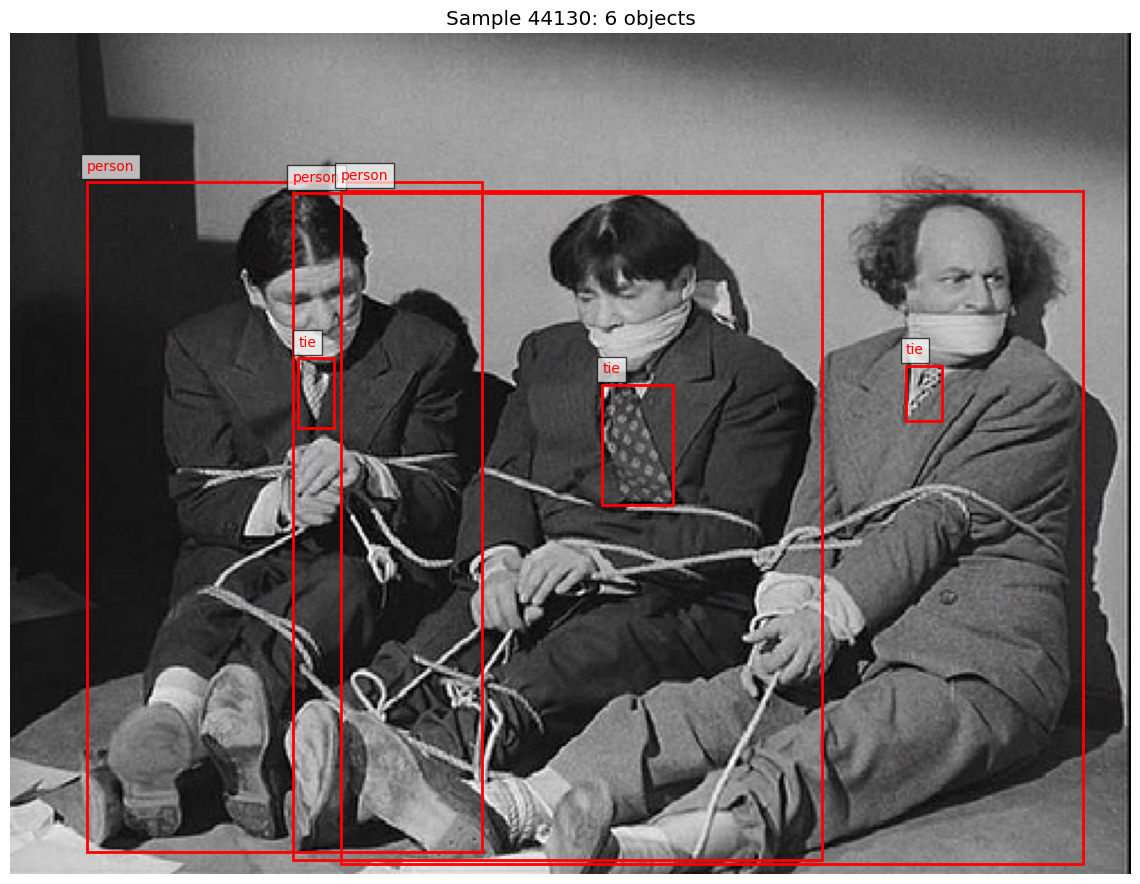

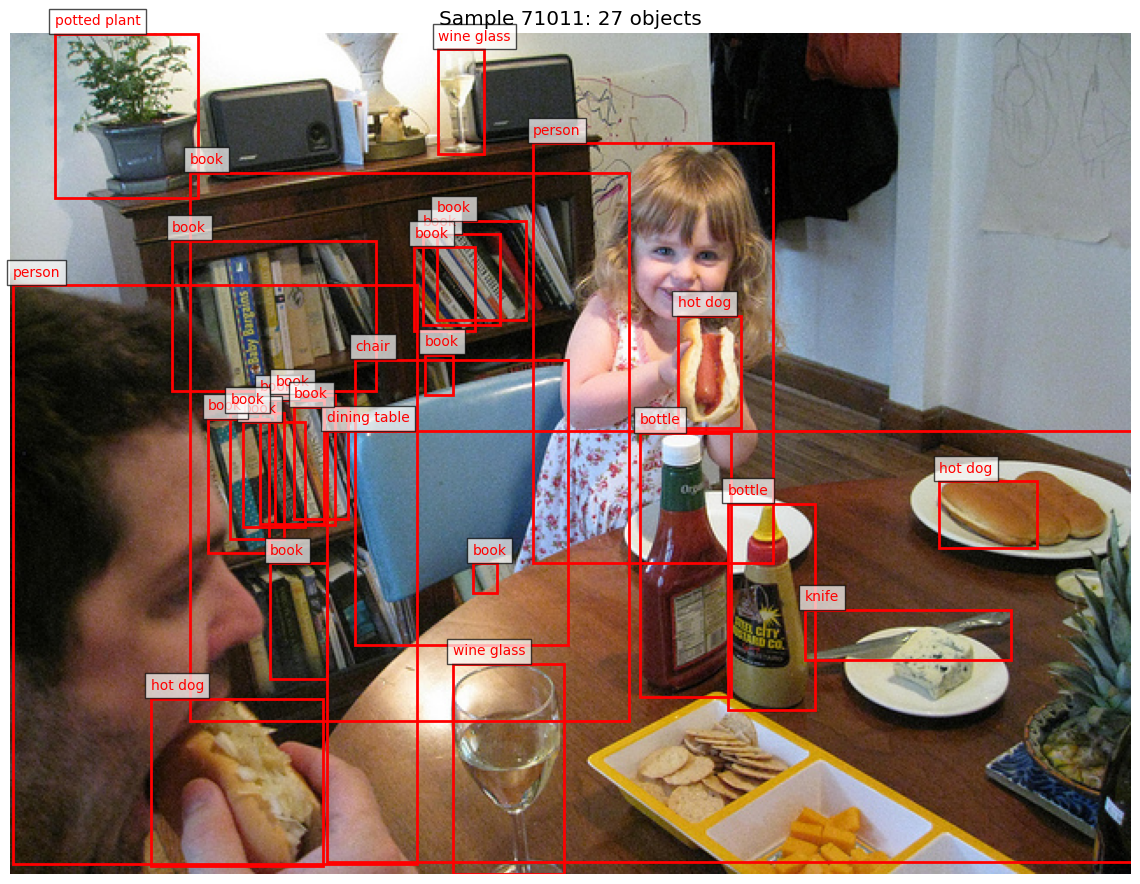

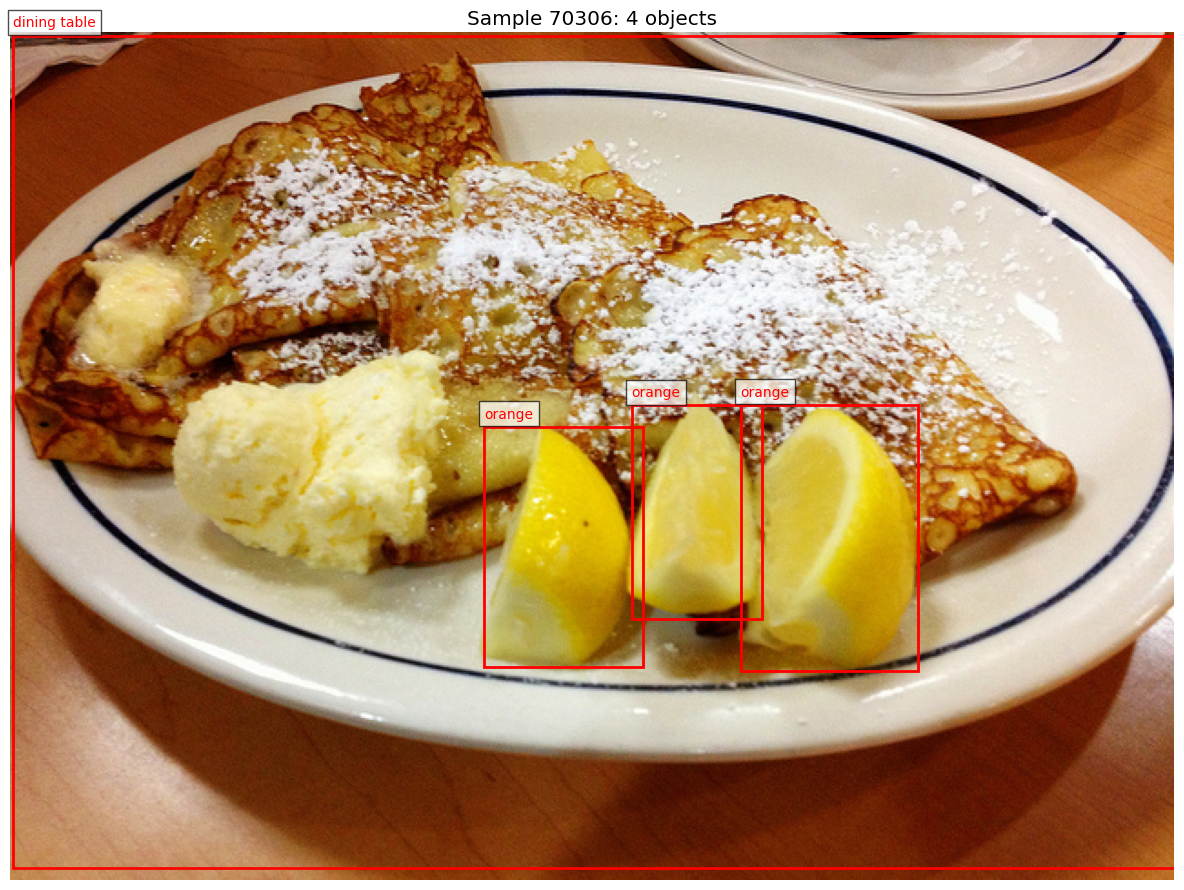

In [11]:
def visualize_samples(dataset, num_samples=5):
    """Visualize random samples from the dataset with annotations"""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, target = dataset[idx]
        
        if isinstance(image, Image.Image):
            image_np = np.array(image)
        else:
            image_np = image.permute(1, 2, 0).numpy()
            
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image_np)
        
        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()
        
        # Draw bounding boxes and labels
        for box, label in zip(boxes, labels):
            # x, y, width, height to x, y, x+width, y+height
            x, y, width, height = box
            rect = patches.Rectangle((x, y), width, height, 
                                    linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            category_name = dataset.get_category_name(label.item())
            ax.text(x, y-5, category_name, color='r', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7))
        
        ax.set_title(f'Sample {idx}: {len(boxes)} objects')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

try:
    visualize_samples(train_dataset)
except Exception as e:
    print(f"Could not visualize samples: {e}")

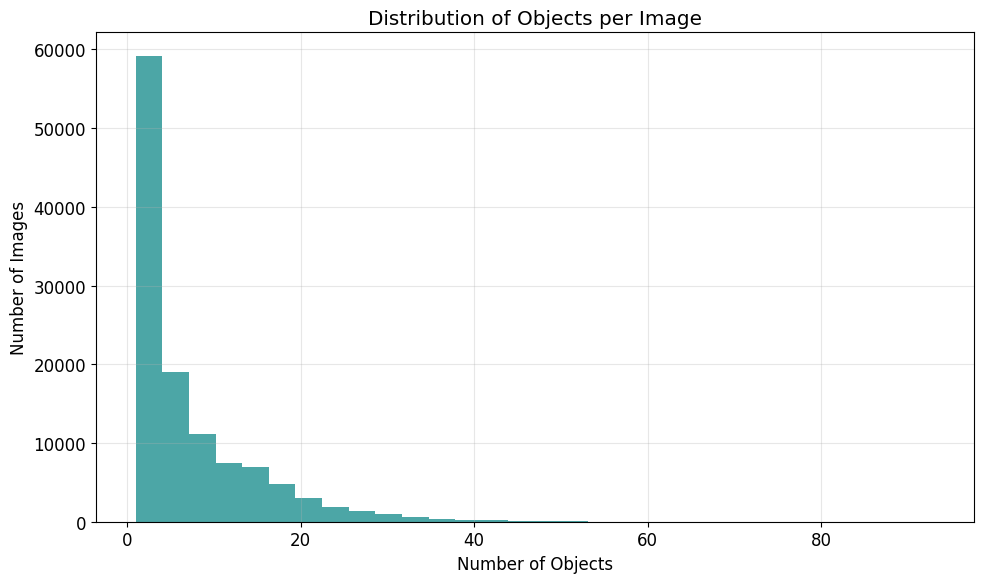

Mean objects per image (non-empty only): 7.33
Median objects per image (non-empty only): 4.00
Maximum objects in one image: 93
Images with no objects: 1021


In [12]:
# Analyze the distribution of objects per image
def analyze_objects_per_image(data):
    img_ids_all = {img['id'] for img in data['images']}
    objects_per_image = Counter()
    for ann in data['annotations']:
        objects_per_image[ann['image_id']] += 1

    covered = set(objects_per_image.keys())
    zero_objs = len(img_ids_all - covered)

    counts = list(objects_per_image.values())
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=30, color='teal', alpha=0.7)
    plt.title('Distribution of Objects per Image')
    plt.xlabel('Number of Objects')
    plt.ylabel('Number of Images')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Mean objects per image (non-empty only): {np.mean(counts):.2f}")
    print(f"Median objects per image (non-empty only): {np.median(counts):.2f}")
    print(f"Maximum objects in one image: {np.max(counts) if counts else 0}")
    print(f"Images with no objects: {zero_objs}")


try:
    analyze_objects_per_image(train_data)
except:
    analyze_objects_per_image(train_dataset.coco_data)

In [13]:
import numpy as np
import torch
from pycocotools import mask as maskUtils

# COCO bbox: [x, y, w, h] → clip у межі зображення
def clip_xywh_to_image(bboxes, H, W):
    b = bboxes.copy()
    b[:, 0] = np.clip(b[:, 0], 0, W-1)
    b[:, 1] = np.clip(b[:, 1], 0, H-1)
    b[:, 2] = np.clip(b[:, 2], 1e-6, W - b[:, 0])  # w
    b[:, 3] = np.clip(b[:, 3], 1e-6, H - b[:, 1])  # h
    return b

# Відсіяти дрібні коробки за площею/мін. розміром сторін
def filter_small_boxes_xywh(bboxes, labels, areas=None, min_area=16.0, min_side=2.0):
    w = bboxes[:, 2]; h = bboxes[:, 3]
    keep = (w >= min_side) & (h >= min_side) & ((w*h) >= min_area)
    b = bboxes[keep]
    l = labels[keep]
    a = areas[keep] if areas is not None else None
    return b, l, a, keep

# COCO segmentation (polygons/RLE) → маски [N, H, W] (uint8)
def decode_segmentations_to_masks(segmentations, H, W):
    masks = []
    for seg in segmentations:
        if isinstance(seg, list):                      # polygons
            rles = maskUtils.frPyObjects(seg, H, W)
            rle = maskUtils.merge(rles)
        elif isinstance(seg, dict) and 'counts' in seg:  # RLE
            rle = seg
        else:
            continue
        m = maskUtils.decode(rle)  # [H,W] {0,1}
        masks.append(m.astype(np.uint8))
    if len(masks) == 0:
        return np.zeros((0, H, W), dtype=np.uint8)
    return np.stack(masks, axis=0)


In [14]:

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def build_train_transform(img_max=1024, stride=32, min_area=16.0, min_visibility=0.0):
    return A.Compose([
        A.LongestMaxSize(max_size=img_max, interpolation=cv2.INTER_LINEAR),

        # ВАЖЛИВО: явно прибираємо min_* і задаємо тільки divisors
        A.PadIfNeeded(
            min_height=None, min_width=None,
            pad_height_divisor=stride, pad_width_divisor=stride,
            border_mode=cv2.BORDER_CONSTANT,
            fill=(114,114,114), fill_mask=0
        ),

        A.Affine(
            scale=(0.85, 1.15),
            translate_percent=(-0.05, 0.05),
            rotate=(-10, 10),
            shear=(-5, 5),
            border_mode=cv2.BORDER_CONSTANT,
            fill=(114,114,114),
            p=0.5
        ),

        A.RandomBrightnessContrast(p=0.30),
        A.ColorJitter(p=0.20),
        A.GaussianBlur(blur_limit=(3,5), p=0.15),

        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='coco', label_fields=['labels'],
        min_area=min_area, min_visibility=min_visibility
    ),
    strict=True)

def build_val_transform(img_max=1024, stride=32):
    return A.Compose([
        A.LongestMaxSize(max_size=img_max, interpolation=cv2.INTER_LINEAR),
        A.PadIfNeeded(
            min_height=None, min_width=None,
            pad_height_divisor=stride, pad_width_divisor=stride,
            border_mode=cv2.BORDER_CONSTANT,
            fill=(114,114,114), fill_mask=0
        ),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='coco', label_fields=['labels'],
        min_area=0.0, min_visibility=0.0
    ),
    strict=True)

In [15]:
from PIL import Image

class COCODatasetWithTransforms(COCODataset):
    def __init__(self, root_dir, annotation_file, transform=None, return_masks=True,
                 min_area_post=16.0, min_side_post=2.0):
        super().__init__(root_dir, annotation_file, transform=None)
        self.albu = transform
        self.return_masks = return_masks
        self.min_area_post = min_area_post
        self.min_side_post = min_side_post

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.images[image_id]
        file_name = img_info['file_name']
        img_path = os.path.join(self.root_dir, file_name)
        image = np.array(Image.open(img_path).convert('RGB'))  # HWC, uint8
        H, W = image.shape[:2]

        anns = self.image_annotations[image_id]
        boxes = []
        labels = []
        areas = []
        segmentations = []
        iscrowd = []

        for ann in anns:
            if 'bbox' in ann:
                boxes.append(ann['bbox'])
                labels.append(ann['category_id'])
                areas.append(ann.get('area', ann['bbox'][2]*ann['bbox'][3]))
                segmentations.append(ann.get('segmentation', None))
                iscrowd.append(ann.get('iscrowd', 0))

        boxes = np.array(boxes, dtype=np.float32) if boxes else np.zeros((0,4), np.float32)
        labels = np.array(labels, dtype=np.int64)   if labels else np.zeros((0,), np.int64)
        areas  = np.array(areas,  dtype=np.float32) if areas  else np.zeros((0,), np.float32)
        iscrowd = np.array(iscrowd, dtype=np.int64) if iscrowd else np.zeros((0,), np.int64)

        # Маски (список HxW), якщо треба
        masks = []
        if self.return_masks and len(segmentations) > 0:
            masks = decode_segmentations_to_masks(segmentations, H, W)
            masks = [m for m in masks]  # Albumentations очікує список масок

        # Clip bbox в межах перед трансформаціями (на випадок «кривих» анотацій)
        if len(boxes):
            boxes = clip_xywh_to_image(boxes, H, W)

        if self.albu is not None:
            # Albumentations потребує списки/маски
            transformed = self.albu(
                image=image,
                bboxes=boxes.tolist(),
                labels=labels.tolist(),
                masks=masks if len(masks) else None
            )
            image = transformed['image']          # Tensor [C,H,W]
            tb = np.array(transformed['bboxes'], dtype=np.float32)
            tl = np.array(transformed['labels'], dtype=np.int64)
            tm = transformed.get('masks', None)

            # Пост-фільтри: дрібні бокси (на випадок, якщо aug їх спотворив)
            if len(tb):
                tb, tl, _, keep = filter_small_boxes_xywh(tb, tl, None,
                                                          min_area=self.min_area_post,
                                                          min_side=self.min_side_post)
                if tm is not None and len(tm):
                    tm = [tm[i] for i, k in enumerate(keep) if k]

            boxes, labels = tb, tl
            if tm is not None:
                # до тензора [N,H,W]
                if len(tm):
                    masks = torch.stack([torch.as_tensor(m, dtype=torch.uint8) for m in tm], dim=0)
                else:
                    masks = torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8)
        else:
            # Без трансформацій — конвертація до Tensor і нормалізація за потреби
            image = torch.from_numpy(image).permute(2,0,1).float()/255.0

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([image_id], dtype=torch.int64),
            'area': torch.as_tensor(areas[:len(labels)] if len(areas) else np.zeros((0,), np.float32)),
            'iscrowd': torch.as_tensor(iscrowd[:len(labels)] if len(iscrowd) else np.zeros((0,), np.int64)),
        }
        if self.return_masks:
            if isinstance(masks, np.ndarray):
                masks = torch.from_numpy(masks.astype(np.uint8))
            if masks is None:
                masks = torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8)
            target['masks'] = masks

        return image, target


In [16]:
from torch.utils.data import DataLoader

def detection_collate(batch):
    images, targets = list(zip(*batch))
    return images, targets  # списки тензорів/словників — стандартно для torchvision моделей

train_tf = build_train_transform(img_max=1024, stride=32, min_area=16.0, min_visibility=0.0)
val_tf   = build_val_transform(img_max=1024, stride=32)

train_ds = COCODatasetWithTransforms(TRAIN_ROOT, TRAIN_ANNOTATION, transform=train_tf, return_masks=True)
val_ds   = COCODatasetWithTransforms(VAL_ROOT,   VAL_ANNOTATION,   transform=val_tf,   return_masks=True)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4,
                          collate_fn=detection_collate, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=4,
                          collate_fn=detection_collate, pin_memory=True)


In [ ]:
import os, time
import torch, torchvision
from torch.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- У COCO category_id не є суцільними індексами (є пропуски).
#      Потрібно ремапнути в [1..num_classes-1] (0 — background).
cat_ids = sorted(list(train_ds.categories.keys()))
id_to_idx = {cid: i+1 for i, cid in enumerate(cat_ids)}  # background=0
idx_to_id = {v: k for k, v in id_to_idx.items()}
num_classes = len(cat_ids) + 1
print("num_classes:", num_classes)

def remap_labels_inplace(targets, id_to_idx):
    for t in targets:
        if len(t["labels"]):
            mapped = [id_to_idx[int(x)] for x in t["labels"].tolist()]
            t["labels"] = torch.as_tensor(mapped, dtype=torch.int64, device=t["labels"].device)

# ---- Модель: вибери USE_MASKS=True для Mask R-CNN або False для Faster R-CNN
USE_MASKS = True

if USE_MASKS:
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=None, num_classes=num_classes
    )
else:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=None, num_classes=num_classes
    )
model.to(device)

# ---- Оптимізатор/скедулер/AMP
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4, nesterov=True)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 11], gamma=0.1)
scaler = GradScaler(device="cuda", enabled=(device.type == "cuda"))

# ---- Хелпери
def move_to_device(images, targets, device):
    images = [im.to(device, non_blocking=True) for im in images]
    # переносимо тільки тензорні поля
    moved = []
    for t in targets:
        t2 = {}
        for k, v in t.items():
            t2[k] = v.to(device, non_blocking=True) if torch.is_tensor(v) else v
        moved.append(t2)
    return images, moved

def filter_empty(images, targets):
    keep_idx = [i for i, t in enumerate(targets) if t["boxes"].numel() and t["boxes"].shape[0] > 0]
    if len(keep_idx) == 0:
        return [], []
    return [images[i] for i in keep_idx], [targets[i] for i in keep_idx]

# ---- Тренування однієї епохи
def train_one_epoch(epoch):
    model.train()
    t0 = time.time()
    running, steps = 0.0, 0
    for step, (images, targets) in enumerate(train_loader, 1):
        # ремап міток + фільтр пустих
        remap_labels_inplace(targets, id_to_idx)
        images, targets = filter_empty(images, targets)
        if not images:
            continue

        images, targets = move_to_device(images, targets, device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == "cuda")):
            losses = model(images, targets)           # dict з компонентами loss
            loss = sum(losses.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item()
        steps += 1
        if step % 50 == 0:
            avg = running / steps
            print(f"[epoch {epoch:02d} | it {step:04d}] loss={avg:.4f}")

    lr_sched.step()
    dt = time.time() - t0
    print(f"Epoch {epoch} done in {dt:.1f}s | train_loss={running/max(steps,1):.4f}")

# ---- Валідація: рахуємо валід. лосс (без градієнтів)
@torch.no_grad()
def validate_one_epoch():
    model.train()  # для обчислення loss'ів потрібен режим train
    total, steps = 0.0, 0
    for images, targets in val_loader:
        remap_labels_inplace(targets, id_to_idx)
        images, targets = filter_empty(images, targets)
        if not images:
            continue
        images, targets = move_to_device(images, targets, device)
        losses = model(images, targets)
        total += sum(v.item() for v in losses.values())
        steps += 1
    avg = total / max(steps, 1)
    print(f"val_loss={avg:.4f}")
    return avg

# ---- Запуск навчання
EPOCHS = 2
best_val = float("inf")
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    train_one_epoch(epoch)
    val_loss = validate_one_epoch()
    # чекпойнт
    if val_loss < best_val:
        best_val = val_loss
        torch.save(
            {"model": model.state_dict(), "epoch": epoch, "val_loss": val_loss,
             "id_to_idx": id_to_idx, "idx_to_id": idx_to_id},
            f"checkpoints/best.pth"
        )
        print("✓ Saved checkpoints/best.pth")

# ---- Швидкий інференс на одному батчі з валідації
model.eval()
with torch.no_grad():
    images, targets = next(iter(val_loader))
    remap_labels_inplace(targets, id_to_idx)
    images_gpu, _ = move_to_device(images, targets, device)
    outputs = model(images_gpu)  # список dict'ів: boxes, labels(ремапнуті), scores,(+masks якщо USE_MASKS)

print("Prediction keys:", outputs[0].keys())
